In [2]:
import sys, scipy
sys.path.append('./../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from systematics_module.corr import *

CMB LENSING 

In [217]:
def brelchisqr(xi, xi2, invcov, brel):
    DiffVector = brel*xi - xi2
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2


def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelarr = np.linspace(0.3, 1.5, 5000)  
    chisqr_result = np.zeros(brelarr.size)
    
    i=0
    for b in brelarr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = brelarr[minarg]
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1, brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    
    
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result

    return err_brel, brel, chisqr_result
    
    

In [155]:
amidir = '/n/des/lee.5922/data/dmass_cat/ami_result/'
meanr, xi = np.loadtxt(amidir+'out_DMASS_mean.out', unpack=True)
meanr, xis = np.loadtxt(amidir+'out_CMASS_South_mean.out', unpack=True)
meanr, xin = np.loadtxt(amidir+'out_CMASS_North_mean.out', unpack=True)


#xi = xi[2:]
#xis = xis[2:]
#xin = xin[2:]
#meanr = meanr[2:]


meanr_th, xi_theory = np.loadtxt('/n/des/lee.5922/data/cmass_cat/cmassnorth_cmbkappa_galbias1p75.asc', unpack=True)
xi_theory = scipy.interpolate.interp1d(meanr_th, xi_theory, kind='cubic')
xi_theory = xi_theory(meanr)



In [157]:
nzs_ratio = np.sqrt(0.9526592040362819)

In [221]:
cov_cmass_n = np.genfromtxt(amidir+'out_CMASS_North.cov')#[2:,2:]
cov_cmass_s = np.genfromtxt(amidir+'out_CMASS_South.cov')#[2:,2:]
cov_dmass = np.genfromtxt(amidir+'out_DMASS.cov')#[2:,2:]

HF = lambda Nr,Nbin: 1#(Nr-Nbin-2) *1./(Nr-1)
HFn = 1. #HF(100, 20)
HFs = 1. #HF(100, 20)
HFd = 1. #HF(100, 20)

print HFn

#F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_cmass_s)
#F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n) + np.linalg.inv(cov_dmass)
#F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s) + np.linalg.inv(cov_dmass)

F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n + cov_cmass_s)
F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n + cov_dmass)
F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s + cov_dmass)

#cov_cmass = np.linalg.inv(F_cmass)

1.0


In [146]:
meanr

array([  1.26192245,   1.88272711,   2.80869276,   4.19031219,
         6.23946012,   9.32583079,  13.92092298,  20.75306354,
        30.95828368,  46.17687335,  68.90167663, 102.78183963])

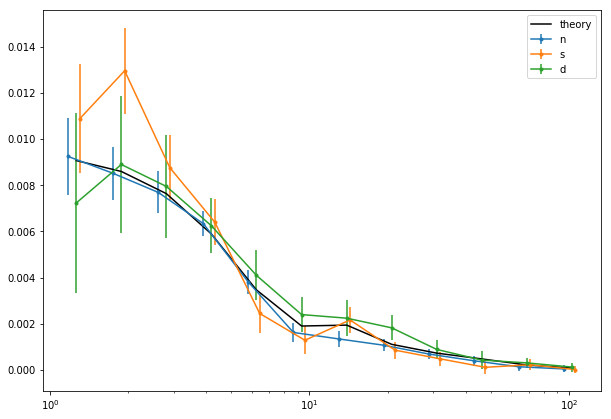

In [161]:
fig, ax = plt.subplots(figsize = (10,7))

ax.errorbar( meanr*0.93, xin, yerr = np.sqrt(cov_cmass_n.diagonal()), fmt='.-', label='n' )
ax.errorbar( meanr*1.03, xis, yerr = np.sqrt(cov_cmass_s.diagonal()), fmt='.-', label='s' )
ax.errorbar( meanr, xi, yerr = np.sqrt(cov_dmass.diagonal()), fmt='.-', label='d' )
ax.plot( meanr, xi_theory, 'k-', label='theory')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()

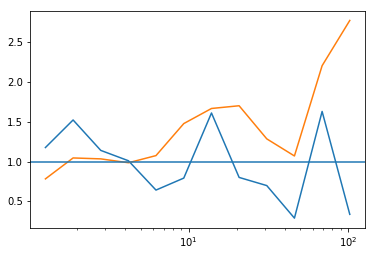

In [167]:
fig, ax = plt.subplots()
ax.semilogx( meanr, xis/xin)
ax.semilogx( meanr, xi/xin)

ax.axhline(y = 1)

In [169]:
mock_n = np.random.multivariate_normal( xi_theory, cov_cmass_n, size=1000 )
mock_s = np.random.multivariate_normal( xi_theory, cov_cmass_s, size=1000 )
mock_d = np.random.multivariate_normal( xi_theory, cov_dmass, size=1000 )

<Container object of 3 artists>

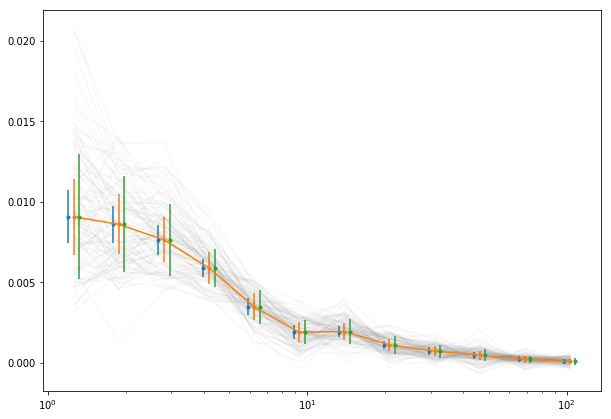

In [98]:
fig, ax = plt.subplots(figsize=(10,7))
for i in range(100): 
    ax.semilogx(meanr, mock_d[i], color='grey', alpha = 0.05)
ax.errorbar(meanr*0.95, xi_theory, yerr=np.sqrt(cov_cmass_n.diagonal()), fmt='.')
ax.errorbar(meanr, xi_theory, yerr=np.sqrt(cov_cmass_s.diagonal()), fmt='.-')
ax.errorbar(meanr*1.05, xi_theory, yerr=np.sqrt(cov_dmass.diagonal()), fmt='.')

In [99]:
mock_n.shape

(5000, 12)

In [224]:
brel_ns = np.zeros(1000)
chisqr_array_ns = np.zeros((1000, 5000))
brel_sd = np.zeros(1000)
chisqr_array_sd = np.zeros((1000, 5000))

brel_nd = np.zeros(1000)
chisqr_array_nd = np.zeros((1000, 5000))

for i in range(1000):
    _, brel_ns[i], chisqr_array_ns[i] = brel_chisqr_fitting(mock_s[i], mock_n[i], F_ns)
    _, brel_nd[i], chisqr_array_nd[i] = brel_chisqr_fitting(mock_d[i], mock_n[i], F_nd)
    _, brel_sd[i], chisqr_array_sd[i] = brel_chisqr_fitting(mock_d[i], mock_s[i], F_sd)
    print i, '\r',
    
bshift_ns= 1./np.mean(brel_ns)
bshift_nd= 1./np.mean(brel_nd)
bshift_sd= 1./np.mean(brel_sd)

print bshift_ns, bshift_nd, bshift_sd

1.0882262152149655 1.1397504085682604 1.1706652413542193


In [225]:
bshift_ns= 1./np.mean(brel_ns)
bshift_nd= 1./np.mean(brel_nd)
bshift_sd= 1./np.mean(brel_sd)


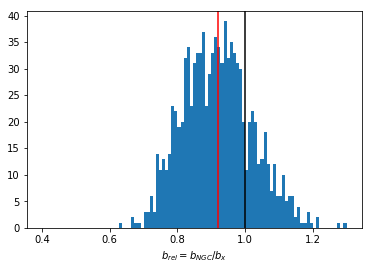

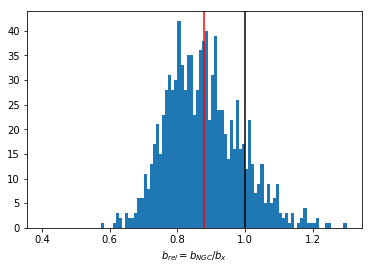

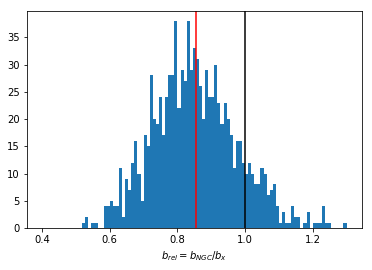

In [226]:
bins, bs = np.linspace(0.4, 1.3, 100, retstep=True)
bincent = bins[:-1] + bs/2.

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_ns, bins = bins)

meanv = np.mean(brel_ns)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')

fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_nd, bins = bins)

meanv = np.mean(brel_nd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')


fig, ax = plt.subplots()
N,_,_ = ax.hist(brel_sd, bins = bins)

meanv = np.mean(brel_sd)
ax.axvline(x = 1.0, color='k')
ax.axvline(x=meanv, color='r')
#ax.set_xlim(0.95, 1.05)
ax.set_xlabel('$b_{rel} = b_{NGC} /b_x$')

In [184]:
nzs_ratio

0.9760426240878427

In [228]:
#err_db_nn, db_nn, chisqr_result_nn = brel_chisqr_fitting(xin, xi_theory, np.linalg.inv(cov_cmass_n))

#err_db_ns, db_ns, chisqr_result_ns = brel_chisqr_fitting(xis, xi_theory, F_ns)
#err_db_nd, db_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xi_theory, F_nd)
#err_db_sd, db_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xis, F_sd)

err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xis, xin, F_ns, verbose=True)
err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi,  xin, F_nd, verbose=True)
err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi,  xis, F_sd, verbose=True)

#err_brel_ns, brel_ns, chisqr_result_ns = brel_chisqr_fitting(xi_theory, xis, np.linalg.inv(cov_cmass_s), verbose=True)
#err_brel_nd, brel_nd, chisqr_result_nd = brel_chisqr_fitting(xi_theory,  xi, np.linalg.inv(cov_dmass), verbose=True)
#err_brel_sd, brel_sd, chisqr_result_sd = brel_chisqr_fitting(xi_theory,  xin, np.linalg.inv(cov_cmass_n), verbose=True)

err db, db / br1, brmin, br2 : 0.2338067613522703 -0.2592818565972932 0.7683336667333467 0.8852370474094817 1.002140428085617
err db, db / br1, brmin, br2 : 0.23572714542908568 -0.5403358995858425 0.6694338867773555 0.7872974594918983 0.9051610322064412
err db, db / br1, brmin, br2 : 0.27677535507101414 -0.5165496237005716 0.6562312462492499 0.7947389477895579 0.933006601320264


In [233]:
print err_brel_ns, ',', brel_ns
print err_brel_nd, ',', brel_nd
print err_brel_sd, ',', brel_sd

0.11690338067613515 , 0.8852370474094817
0.11786357271454284 , 0.7872974594918983
0.13838767753550707 , 0.7947389477895579


8.536439836595713
3.3666083200657657
4.207379820169941
0.7113699863829761
0.28055069333881383
0.3506149850141618


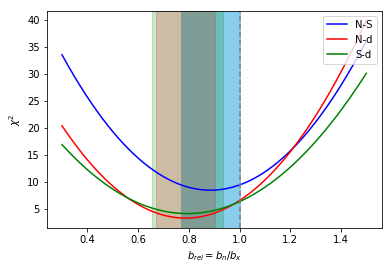

In [234]:
fig, ax = plt.subplots()

b_n = 2.0
brel = np.linspace(0.3, 1.5, 5000)    
dbarray = b_n*(1-brel)

#ax.plot(dbarray, chisqr_result_nn, '-k', label='N-N')
ax.plot(brel, chisqr_result_ns, '-b', label='N-S')
ax.plot(brel, chisqr_result_nd, '-r',label='N-d')
ax.plot(brel, chisqr_result_sd, '-g',label='S-d')

#ax.plot(brel, chisqr_result_nd_new, '-m',label='N-d2')
#ax.plot(dbarray, chisqr_result_ns_nzs_ratio, color='orange', ls='--',label='N-S nzs_ratio')

#ax.errorbar(db_ns, chisqr_min_ns, xerr =err_brel_ns *b_cmass)
#ax.errorbar(db_nd, chisqr_min_nd, xerr =err_brel_nd *b_cmass)
#ax.errorbar(db_sd, chisqr_min_sd, xerr =err_brel_sd *b_cmass)

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)

#ax.axvspan(db_nn-err_db_nn, db_nn+err_db_nn, alpha=0.2, color='grey')
ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')
ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
#ax.axvspan(db_ns_nzs_ratio-err_db_ns_nzs_ratio, db_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')

ax.axvline(x=1.0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_n/b_x$')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

print chisqr_result_ns.min()
print chisqr_result_nd.min()
print chisqr_result_sd.min()


print chisqr_result_ns.min()/12
print chisqr_result_nd.min()/12
print chisqr_result_sd.min()/12

#ax.set_xlim(0.88, 1.06)

0.1272173234990249 , 0.9633381616704914
0.13433505515671507 , 0.8973226011206445
0.16200564392255426 , 0.9303732621276611


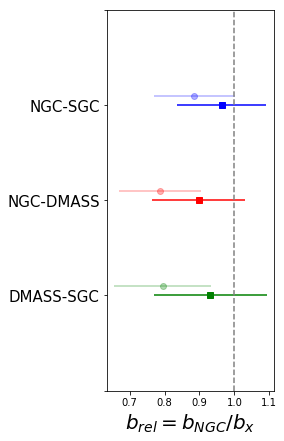

In [232]:
fig, ax = plt.subplots(figsize = (3,7))

brelsqr = np.linspace(0.8, 1.5, 50000) 
b_n = 2.0
brel = np.sqrt(brelsqr)
dbarray = b_n*(1-brel)

ax.errorbar(brel_ns, 3.1, xerr =err_brel_ns, fmt='-o', color='blue', alpha = 0.3)
ax.errorbar(brel_nd, 2.1, xerr =err_brel_nd, fmt='-o', color = 'red', alpha = 0.3)
ax.errorbar(brel_sd, 1.1, xerr =err_brel_sd, fmt='-o', color = 'green', alpha = 0.3)

ax.errorbar(brel_ns*bshift_ns, 3, xerr =err_brel_ns*bshift_ns, fmt='-s', color='blue')
ax.errorbar(brel_nd*bshift_nd, 2, xerr =err_brel_nd*bshift_nd, fmt='-s', color = 'red')
ax.errorbar(brel_sd*bshift_sd, 1, xerr =err_brel_sd*bshift_sd, fmt='-s', color = 'green')

print err_brel_ns*bshift_ns, ',', brel_ns*bshift_ns
print err_brel_nd*bshift_nd, ',', brel_nd*bshift_nd
print err_brel_sd*bshift_sd, ',', brel_sd*bshift_sd

#ax.errorbar(brel_ns_nzs_ratio, 2, xerr = err_brel_ns_nzs_ratio, fmt='-o', color='orange')

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)
#ax.axvspan(brel_ns-err_brel_ns, brel_ns+err_brel_ns, alpha=0.99, color='skyblue')

#ax.axvspan(brel_sd-err_brel_sd, brel_sd+err_brel_sd, alpha=0.2, color='green')
#ax.axvspan(brel_ns_nzs_ratio-err_brel_ns_nzs_ratio, brel_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')
#ax.axvspan(brel_nd-err_brel_nd, brel_nd+err_brel_nd, alpha=0.2, color='red')
ax.axvline(x=1.0, color = 'grey', ls='--')
#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$b_{rel} = b_{NGC}/b_{x}$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(0.94, 1.1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)

ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['','DMASS-SGC','NGC-DMASS', 'NGC-SGC' ,''], fontsize = 15) 
#print chi2.sf(chisqr_min_ns,9), chi2.sf(chisqr_min_nd,9), chi2.sf(chisqr_min_sd,9)
#print chi2.sf(chinull_ns,9), chi2.sf(chinull_nd,9), chi2.sf(chinull_sd,9)

NameError: name 'db_ns' is not defined

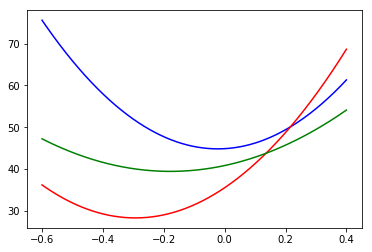

In [22]:
fig, ax = plt.subplots()

b_n = 2.0
brel = np.linspace(0.8, 1.3, 50000)  
dbarray = b_n*(1-brel)

#ax.plot(dbarray, chisqr_result_nn, '-k', label='N-N')
ax.plot(dbarray, chisqr_result_ns, '-b', label='N-S')
ax.plot(dbarray, chisqr_result_nd, '-r',label='N-d')
ax.plot(dbarray, chisqr_result_sd, '-g',label='S-d')
#ax.plot(dbarray, chisqr_result_ns_nzs_ratio, color='orange', ls='--',label='N-S nzs_ratio')

#ax.axvline(x = -0.020420408408168278)
#ax.axvline(x = 0.29054581091621845)
#ax.axvline(x = 0.07538150763015272)
#ax.errorbar(db_ns, chisqr_min_ns, xerr =err_brel_ns *b_cmass)
#ax.errorbar(db_nd, chisqr_min_nd, xerr =err_brel_nd *b_cmass)
#ax.errorbar(db_sd, chisqr_min_sd, xerr =err_brel_sd *b_cmass)

#ax.axvline(db_ns, lw = err_brel_ns *b_cmass, alpha = 0.5)

#ax.axvspan(db_nn-err_db_nn, db_nn+err_db_nn, alpha=0.2, color='grey')
ax.axvspan(db_ns-err_db_ns, db_ns+err_db_ns, alpha=0.99, color='skyblue')
ax.axvspan(db_nd-err_db_nd, db_nd+err_db_nd, alpha=0.2, color='red')
ax.axvspan(db_sd-err_db_sd, db_sd+err_db_sd, alpha=0.2, color='green')
#ax.axvspan(db_ns_nzs_ratio-err_db_ns_nzs_ratio, db_ns_nzs_ratio+err_db_ns_nzs_ratio, alpha=0.2, color='orange')

#ax.axvline(x=0, color = 'grey', ls='--')

ax.set_xlabel(r'$\Delta b$')
ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.axhline(y = chisqr_min_ns+1)
#ax.axhline(y = chisqr_min_nd+1)
#ax.axhline(y = chisqr_min_sd+1)



0.9178178178178178 0.9580280882196606
-0.08762146391414749


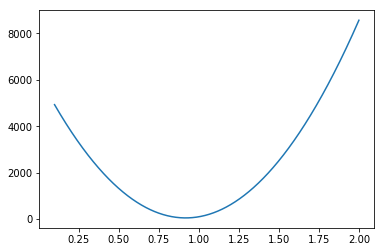

In [253]:
brelsqr = np.linspace(0.1, 2.0, 1000)
chisqr_result = np.zeros(brelsqr.size)

i=0
for b in brelsqr:
    chisqr_result[i] = brelchisqr(xi, xi11, F_cmass, b)
    i+=1

minarg = chisqr_result.argmin()
print brelsqr[minarg], np.sqrt(brelsqr[minarg])
brel = np.sqrt(brelsqr[minarg])
bcmass = 2.0
db = bcmass * (1. - 1./brel)
print db


fig, ax = plt.subplots()
ax.plot(brelsqr, chisqr_result)

In [249]:
1. - 1./np.sqrt(brelsqr[minarg])

-0.0525717487359747

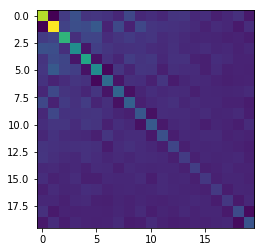

In [197]:
fig, ax = plt.subplots()
ax.imshow(cov_cmass)